# GAN CNN

This notebook corresponds to the model that gave the best results

In [2]:
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D,LSTM, BatchNormalization, Conv2DTranspose,Flatten, Input, Reshape, UpSampling2D,ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import math

## Data generation and preprocessing

We generate samples of Lorentz-63 trajectories with dt=0.1 and T=100. We transform those trajectories in images of size 32x32x3 (one channel for each coordinate) in order to be able to use GANs with CNNs

In [40]:
def generate_data_as_images(N,l=100,T=1, dt = 0.001,n_rows=32,n_cols=32):
    
    #Model parameters
    #dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    
    #T = dt*(l+1)
    #dt = T/(l+1)
    
    #X = np.zeros((N,3*(l-9)))
    X = []
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, np.arange(0.01,T,dt), args=(sigma, rho, beta))
        
        x_padded = np.zeros((n_rows*n_cols,x.shape[1]))
        x_padded[:x.shape[0],:] = x
        x_padded = x_padded.reshape(n_rows,n_cols,x.shape[1])
        
        #X[n,...] = np.ndarray.flatten(x)
        #X.append(np.ndarray.flatten(x))
        X.append(x_padded)
        #X.append(x.reshape(x.shape[0]*x.shape[1]))

    return np.array(X)

# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = np.zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [41]:
N = 100
n_rows = 32
n_cols = 32

X = generate_data_as_images(N,T=100, dt=0.1,n_rows=n_rows,n_cols=n_cols)

X.shape

(100, 32, 32, 3)

## Model definition and training

In [69]:
class gan_CNN(object): 

    def __init__(self):

        self.noise_dim = 300
        self.img_cols = 32
        self.img_rows = 32
        self.channels = 3
        self.optimizer_gan = Adam(0.0001, 0.5)
        self.optimizer_discriminator = Adam(0.0004, 0.5)

        
        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()

    def create_generator(self):
        
        # Starting size
        d = 2
        self.generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=self.noise_dim))
        self.generator.add(LeakyReLU(0.2))
        # 4x4x256
        self.generator.add(Reshape((d, d, 256)))
        
        # 8x8x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 16x16*128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x3
        self.generator.add(Conv2D(self.channels, (3, 3), padding='same', activation='linear', kernel_initializer=RandomNormal(0, 0.02)))
        # activation should be linear
        
        self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer_gan)
        # maybe put a batch normalzation layer
      
    def create_discriminator(self):

        self.discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(self.img_cols, self.img_rows, self.channels)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Flatten())
        self.discriminator.add(Dropout(0.4))
        self.discriminator.add(Dense(1, activation='sigmoid', input_shape=(self.img_cols, self.img_rows, self.channels)))

        self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer_discriminator)

    def create_gan(self):

        # Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
        self.discriminator.trainable = False

        # Link the two models to create the GAN
        gan_input = Input(shape=(self.noise_dim,))
        print(gan_input.shape)
        fake_image = self.generator(gan_input)

        gan_output = self.discriminator(fake_image)

        self.gan = Model(gan_input, gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=self.optimizer_gan)
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = math.ceil((X_train.shape[0] / batch_size))

        loss_list_generator = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss_generator = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])
            
            max_noise = 10
            if e < 0.2 * (epochs+1):
                noise_std = max_noise
            elif e < 0.4 * (epochs+1):
                noise_std = max_noise
            elif e < 0.6 * (epochs+1):
                noise_std = max_noise/2
            elif e < 0.8 * (epochs+1):
                noise_std = max_noise/6
            elif e < 0.9 * (epochs+1):
                noise_std = max_noise/10
            else:
                noise_std = 0
                
            print('Noise std: ', noise_std)

            for _ in tqdm(range(batch_count)):
                
                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size
                #real_trajectory = real_trajectory.reshape(N, self.img_rows, self.img_cols, self.channels)
                #generate  random noise as an input  to  initialize the  generator
                
                #noise= np.random.normal(0,1, [N, self.noise_dim])

                generated_trajectory = self.generate(N)
                
                #Construct different batches of  real and fake data 
                X= np.concatenate([real_trajectory, generated_trajectory], axis=0) + noise_std * np.random.randn(2*N,n_rows,n_cols,1)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 0.1 #0.9bat
                y_dis[N:2*N]= 0.9 #0.2bat
                
                # we try the discriminator in about one third of the total cases
                if e % e == 0:

                    #Pre train discriminator on  fake and real data  before starting the gan. 
                    self.discriminator.trainable=True

                    loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)

                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N, self.noise_dim])
                y_gen = np.zeros(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss_generator = loss_generator + self.gan.train_on_batch(noise, y_gen)
                
            if e % 3 != 0 and e != 1:
                
                loss_discriminator = loss_list_discriminator[-1]
                
            loss_list_generator.append(loss_generator)
            loss_list_discriminator.append(loss_discriminator)
                                           
            print('Generator loss: ',loss_generator)
            print('Discriminator loss: ',loss_discriminator)
            
            if e == 1 or e % 20 == 0 or e==epochs:

                plt.imshow(X[0,...])
                plt.title('Real image')
                plt.show()
                plt.title('Fake image')
                plt.imshow(X[-1,...])
                plt.show()
                
        return loss_list_generator, loss_list_discriminator

            
    def generate(self,N):

        noise= np.random.normal(0,1, [N, self.noise_dim])

        return self.generator.predict(noise)
    
    def save_weights(self, gen_name, discr_name):
        
        self.generator.save_weights(gen_name)
        self.discriminator.save_weights(discr_name)
        
    def load_weights(self, gen_name, discr_name):
        
        self.generator.load_weights(gen_name)
        self.discriminator.load_weights(discr_name)
      

In [70]:
g_CNN=gan_CNN()
g_CNN.generator_summary()
g_CNN.discriminator_summary()
g_CNN.gan_summary()

(None, 300)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1024)              308224    
_________________________________________________________________
leaky_re_lu_120 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_50 (Conv2DT (None, 4, 4, 128)         131200    
_________________________________________________________________
batch_normalization_106 (Bat (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_121 (LeakyReLU)  (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_51 (Conv2DT (None, 8, 8,

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
Noise std:  10


100%|██████████| 5/5 [00:01<00:00,  4.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.5965230762958527
Discriminator loss:  1.7234327495098114


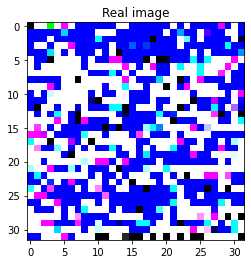

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


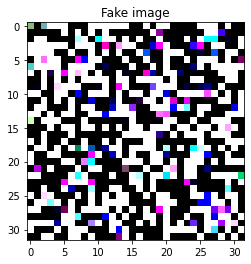

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5297747105360031
Discriminator loss:  1.7234327495098114
Epoch 3
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4579997882246971
Discriminator loss:  1.7342232167720795
Epoch 4
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4738902822136879
Discriminator loss:  1.7342232167720795
Epoch 5
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.41593221575021744
Discriminator loss:  1.7342232167720795
Epoch 6
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3444903865456581
Discriminator loss:  1.740735501050949
Epoch 7
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3699508011341095
Discriminator loss:  1.740735501050949
Epoch 8
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.41143275797367096
Discriminator loss:  1.740735501050949
Epoch 9
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.39011991769075394
Discriminator loss:  1.7251128554344177
Epoch 10
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.28823133558034897
Discriminator loss:  1.7251128554344177
Epoch 11
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.34127092733979225
Discriminator loss:  1.7251128554344177
Epoch 12
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.27921590954065323
Discriminator loss:  1.7318462133407593
Epoch 13
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.27555573359131813
Discriminator loss:  1.7318462133407593
Epoch 14
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3099333718419075
Discriminator loss:  1.7318462133407593
Epoch 15
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.23884059116244316
Discriminator loss:  1.727474957704544
Epoch 16
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2558722458779812
Discriminator loss:  1.727474957704544
Epoch 17
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.24213935807347298
Discriminator loss:  1.727474957704544
Epoch 18
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.25414541363716125
Discriminator loss:  1.7231685519218445
Epoch 19
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.26512323692440987
Discriminator loss:  1.7231685519218445
Epoch 20
Noise std:  10


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.2562953606247902
Discriminator loss:  1.7231685519218445


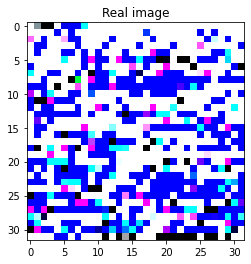

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


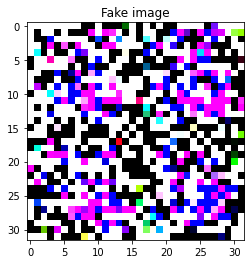

 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Epoch 21
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.21227196231484413
Discriminator loss:  1.7334037721157074
Epoch 22
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.18668336048722267
Discriminator loss:  1.7334037721157074
Epoch 23
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.23830977454781532
Discriminator loss:  1.7334037721157074
Epoch 24
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2047303169965744
Discriminator loss:  1.7252181470394135
Epoch 25
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.23932959884405136
Discriminator loss:  1.7252181470394135
Epoch 26
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  0.18770037218928337
Discriminator loss:  1.7252181470394135
Epoch 27
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.16447902843356133
Discriminator loss:  1.731813222169876
Epoch 28
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.169935068115592
Discriminator loss:  1.731813222169876
Epoch 29
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.23511048033833504
Discriminator loss:  1.731813222169876
Epoch 30
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.2174190953373909
Discriminator loss:  1.7078408598899841
Epoch 31
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.19060920923948288
Discriminator loss:  1.7078408598899841
Epoch 32
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.24605360627174377
Discriminator loss:  1.7078408598899841
Epoch 33
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.20055895298719406
Discriminator loss:  1.7040484547615051
Epoch 34
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.24760129302740097
Discriminator loss:  1.7040484547615051
Epoch 35
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.17606258764863014
Discriminator loss:  1.7040484547615051
Epoch 36
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.17919756285846233
Discriminator loss:  1.71864652633667
Epoch 37
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.16024827770888805
Discriminator loss:  1.71864652633667
Epoch 38
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2083115503191948
Discriminator loss:  1.71864652633667
Epoch 39
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.21620576828718185
Discriminator loss:  1.707164227962494
Epoch 40
Noise std:  10


100%|██████████| 5/5 [00:01<00:00,  4.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.20851188898086548
Discriminator loss:  1.707164227962494


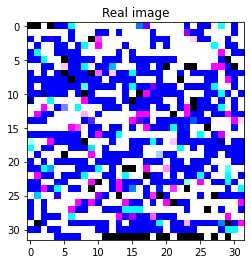

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


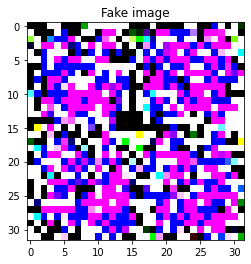

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.17953841388225555
Discriminator loss:  1.707164227962494
Epoch 42
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2104189656674862
Discriminator loss:  1.7116312980651855
Epoch 43
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2626248821616173
Discriminator loss:  1.7116312980651855
Epoch 44
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.21903900429606438
Discriminator loss:  1.7116312980651855
Epoch 45
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.1948169395327568
Discriminator loss:  1.7178353667259216
Epoch 46
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.18240518495440483
Discriminator loss:  1.7178353667259216
Epoch 47
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2545025460422039
Discriminator loss:  1.7178353667259216
Epoch 48
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.27121638506650925
Discriminator loss:  1.697680801153183
Epoch 49
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.26471618562936783
Discriminator loss:  1.697680801153183
Epoch 50
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.22030912898480892
Discriminator loss:  1.697680801153183
Epoch 51
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.30874863266944885
Discriminator loss:  1.7042259871959686
Epoch 52
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.1880161464214325
Discriminator loss:  1.7042259871959686
Epoch 53
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2919200509786606
Discriminator loss:  1.7042259871959686
Epoch 54
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.29521217197179794
Discriminator loss:  1.6973308324813843
Epoch 55
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.24728592857718468
Discriminator loss:  1.6973308324813843
Epoch 56
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.32744690030813217
Discriminator loss:  1.6973308324813843
Epoch 57
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3074633404612541
Discriminator loss:  1.689860612154007
Epoch 58
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.30677593126893044
Discriminator loss:  1.689860612154007
Epoch 59
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.24196832254529
Discriminator loss:  1.689860612154007
Epoch 60
Noise std:  10


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.18835722468793392
Discriminator loss:  1.6929506659507751


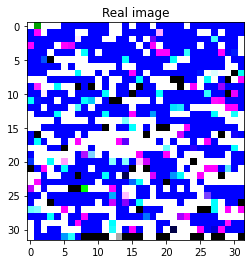

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


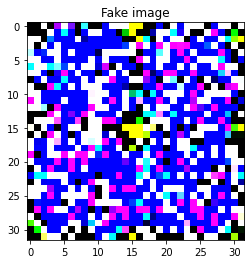

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.19012957625091076
Discriminator loss:  1.6929506659507751
Epoch 62
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.19740822538733482
Discriminator loss:  1.6929506659507751
Epoch 63
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.22608959674835205
Discriminator loss:  1.70598566532135
Epoch 64
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.25796376168727875
Discriminator loss:  1.70598566532135
Epoch 65
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2844039611518383
Discriminator loss:  1.70598566532135
Epoch 66
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2527867443859577
Discriminator loss:  1.6922785639762878
Epoch 67
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.383854765444994
Discriminator loss:  1.6922785639762878
Epoch 68
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.26268067955970764
Discriminator loss:  1.6922785639762878
Epoch 69
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.20783010125160217
Discriminator loss:  1.6979945600032806
Epoch 70
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.18356523849070072
Discriminator loss:  1.6979945600032806
Epoch 71
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.19309822842478752
Discriminator loss:  1.6979945600032806
Epoch 72
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.16498133540153503
Discriminator loss:  1.6916062235832214
Epoch 73
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.20688668452203274
Discriminator loss:  1.6916062235832214
Epoch 74
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.21699292585253716
Discriminator loss:  1.6916062235832214
Epoch 75
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.16824191808700562
Discriminator loss:  1.6900233924388885
Epoch 76
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.15785330533981323
Discriminator loss:  1.6900233924388885
Epoch 77
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.1786247342824936
Discriminator loss:  1.6900233924388885
Epoch 78
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.14635604433715343
Discriminator loss:  1.698735922574997
Epoch 79
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.13905968330800533
Discriminator loss:  1.698735922574997
Epoch 80
Noise std:  10


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.11522877216339111
Discriminator loss:  1.698735922574997


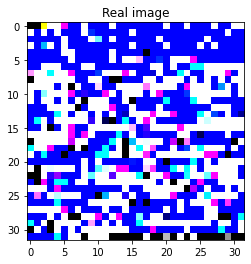

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


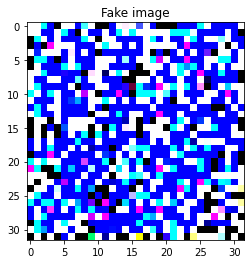

 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Epoch 81
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.13952679559588432
Discriminator loss:  1.7071994245052338
Epoch 82
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.16919981874525547
Discriminator loss:  1.7071994245052338
Epoch 83
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.17791776359081268
Discriminator loss:  1.7071994245052338
Epoch 84
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2487233802676201
Discriminator loss:  1.7036330103874207
Epoch 85
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2962103635072708
Discriminator loss:  1.7036330103874207
Epoch 86
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  0.27001180313527584
Discriminator loss:  1.7036330103874207
Epoch 87
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.22912757471203804
Discriminator loss:  1.6734970808029175
Epoch 88
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.67it/s]

Generator loss:  0.19119681790471077
Discriminator loss:  1.6734970808029175
Epoch 89
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.22844639234244823
Discriminator loss:  1.6734970808029175
Epoch 90
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.17962573654949665
Discriminator loss:  1.683562844991684
Epoch 91
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.49it/s]

Generator loss:  0.16784171015024185
Discriminator loss:  1.683562844991684
Epoch 92
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.36it/s]

Generator loss:  0.15326762199401855
Discriminator loss:  1.683562844991684
Epoch 93
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.16333710215985775
Discriminator loss:  1.6735373139381409
Epoch 94
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.68it/s]

Generator loss:  0.17879980988800526
Discriminator loss:  1.6735373139381409
Epoch 95
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.62it/s]

Generator loss:  0.12954918667674065
Discriminator loss:  1.6735373139381409
Epoch 96
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.11703860200941563
Discriminator loss:  1.6986956298351288
Epoch 97
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.1838442161679268
Discriminator loss:  1.6986956298351288
Epoch 98
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.51it/s]

Generator loss:  0.3103778585791588
Discriminator loss:  1.6986956298351288
Epoch 99
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  0.2939421012997627
Discriminator loss:  1.6752096712589264
Epoch 100
Noise std:  10


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.30329639837145805
Discriminator loss:  1.6752096712589264


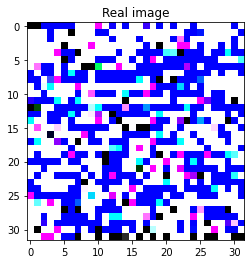

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


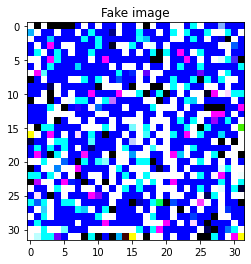

 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Epoch 101
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.2913337014615536
Discriminator loss:  1.6752096712589264
Epoch 102
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  0.25351353734731674
Discriminator loss:  1.6734293401241302
Epoch 103
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.2639656662940979
Discriminator loss:  1.6734293401241302
Epoch 104
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.25845910981297493
Discriminator loss:  1.6734293401241302
Epoch 105
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.18948158621788025
Discriminator loss:  1.6744731962680817
Epoch 106
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  0.2028340231627226
Discriminator loss:  1.6744731962680817
Epoch 107
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.36it/s]

Generator loss:  0.20590931922197342
Discriminator loss:  1.6744731962680817
Epoch 108
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  0.21409448981285095
Discriminator loss:  1.6725720465183258
Epoch 109
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.55it/s]

Generator loss:  0.17735492996871471
Discriminator loss:  1.6725720465183258
Epoch 110
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.2110571414232254
Discriminator loss:  1.6725720465183258
Epoch 111
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.31663988158106804
Discriminator loss:  1.6923400461673737
Epoch 112
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  0.3296760246157646
Discriminator loss:  1.6923400461673737
Epoch 113
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  5.065507996827364
Discriminator loss:  1.6923400461673737
Epoch 114
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.55it/s]

Generator loss:  21.888911724090576
Discriminator loss:  1.794422060251236
Epoch 115
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  29.716845512390137
Discriminator loss:  1.794422060251236
Epoch 116
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Generator loss:  29.71108865737915
Discriminator loss:  1.794422060251236
Epoch 117
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  20.60500693321228
Discriminator loss:  1.7241749465465546
Epoch 118
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.46it/s]

Generator loss:  16.772184371948242
Discriminator loss:  1.7241749465465546
Epoch 119
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  14.208144426345825
Discriminator loss:  1.7241749465465546
Epoch 120
Noise std:  10


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  11.540385246276855
Discriminator loss:  1.6894696056842804


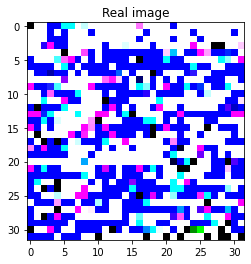

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


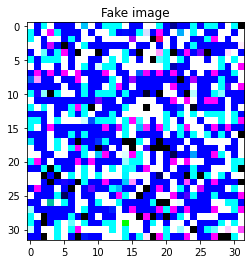

 20%|██        | 1/5 [00:00<00:00,  5.77it/s]

Epoch 121
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.80it/s]

Generator loss:  4.66267317533493
Discriminator loss:  1.6894696056842804
Epoch 122
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  14.689489364624023
Discriminator loss:  1.6894696056842804
Epoch 123
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  30.501808166503906
Discriminator loss:  1.7371467053890228
Epoch 124
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.62it/s]

Generator loss:  43.180357933044434
Discriminator loss:  1.7371467053890228
Epoch 125
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.91it/s]

Generator loss:  35.99947500228882
Discriminator loss:  1.7371467053890228
Epoch 126
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  35.40558338165283
Discriminator loss:  1.7070105969905853
Epoch 127
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.81it/s]

Generator loss:  31.254306316375732
Discriminator loss:  1.7070105969905853
Epoch 128
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  27.79022216796875
Discriminator loss:  1.7070105969905853
Epoch 129
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.41it/s]

Generator loss:  27.53237533569336
Discriminator loss:  1.6874205470085144
Epoch 130
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  25.608144760131836
Discriminator loss:  1.6874205470085144
Epoch 131
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.80it/s]

Generator loss:  25.13634443283081
Discriminator loss:  1.6874205470085144
Epoch 132
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  21.113330841064453
Discriminator loss:  1.679832637310028
Epoch 133
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  16.41832947731018
Discriminator loss:  1.679832637310028
Epoch 134
Noise std:  10


 20%|██        | 1/5 [00:00<00:00,  5.50it/s]

Generator loss:  23.061316967010498
Discriminator loss:  1.679832637310028
Epoch 135
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  29.97602415084839
Discriminator loss:  1.6939561069011688
Epoch 136
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  34.49443340301514
Discriminator loss:  1.6939561069011688
Epoch 137
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  27.958091735839844
Discriminator loss:  1.6939561069011688
Epoch 138
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  25.47034215927124
Discriminator loss:  1.676024705171585
Epoch 139
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  28.996741771697998
Discriminator loss:  1.676024705171585
Epoch 140
Noise std:  10


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  25.81224298477173
Discriminator loss:  1.676024705171585


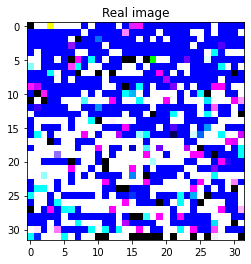

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


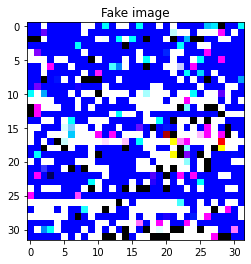

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  19.624682188034058
Discriminator loss:  1.699463039636612
Epoch 142
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  16.881021976470947
Discriminator loss:  1.699463039636612
Epoch 143
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  36.7813286781311
Discriminator loss:  1.699463039636612
Epoch 144
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  50.17009449005127
Discriminator loss:  1.7063466608524323
Epoch 145
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  45.51041793823242
Discriminator loss:  1.7063466608524323
Epoch 146
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  44.46879196166992
Discriminator loss:  1.7063466608524323
Epoch 147
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  42.284390926361084
Discriminator loss:  1.6947760581970215
Epoch 148
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  31.173011302947998
Discriminator loss:  1.6947760581970215
Epoch 149
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  20.402241230010986
Discriminator loss:  1.6947760581970215
Epoch 150
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  11.929055094718933
Discriminator loss:  1.6953705847263336
Epoch 151
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  6.527571618556976
Discriminator loss:  1.6953705847263336
Epoch 152
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.141718566417694
Discriminator loss:  1.6953705847263336
Epoch 153
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.636054337024689
Discriminator loss:  1.785378485918045
Epoch 154
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.6842773258686066
Discriminator loss:  1.785378485918045
Epoch 155
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.811159193515778
Discriminator loss:  1.785378485918045
Epoch 156
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  9.438620686531067
Discriminator loss:  1.7451354563236237
Epoch 157
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.0842540487647057
Discriminator loss:  1.7451354563236237
Epoch 158
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.385100468993187
Discriminator loss:  1.7451354563236237
Epoch 159
Noise std:  10


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.36232685297727585
Discriminator loss:  1.68872931599617
Epoch 160
Noise std:  10


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.2796655632555485
Discriminator loss:  1.68872931599617


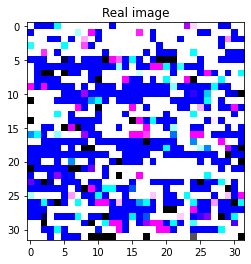

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


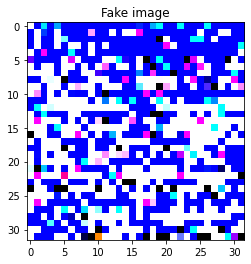

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3480588272213936
Discriminator loss:  1.68872931599617
Epoch 162
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.29012593254446983
Discriminator loss:  1.666541188955307
Epoch 163
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2843867167830467
Discriminator loss:  1.666541188955307
Epoch 164
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3880002871155739
Discriminator loss:  1.666541188955307
Epoch 165
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.32606425136327744
Discriminator loss:  1.6639641523361206
Epoch 166
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4335997402667999
Discriminator loss:  1.6639641523361206
Epoch 167
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5011514276266098
Discriminator loss:  1.6639641523361206
Epoch 168
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4644959941506386
Discriminator loss:  1.6569617092609406
Epoch 169
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.526491142809391
Discriminator loss:  1.6569617092609406
Epoch 170
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6707119792699814
Discriminator loss:  1.6569617092609406
Epoch 171
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.6116057485342026
Discriminator loss:  1.6670991778373718
Epoch 172
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  17.384751319885254
Discriminator loss:  1.6670991778373718
Epoch 173
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  34.97617864608765
Discriminator loss:  1.6670991778373718
Epoch 174
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  37.724918365478516
Discriminator loss:  1.6920062899589539
Epoch 175
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  41.953176975250244
Discriminator loss:  1.6920062899589539
Epoch 176
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Generator loss:  39.66475963592529
Discriminator loss:  1.6920062899589539
Epoch 177
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  31.953985691070557
Discriminator loss:  1.7074893116950989
Epoch 178
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  21.999325037002563
Discriminator loss:  1.7074893116950989
Epoch 179
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  20.180642127990723
Discriminator loss:  1.7074893116950989
Epoch 180
Noise std:  5.0


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  20.294766426086426
Discriminator loss:  1.6774397194385529


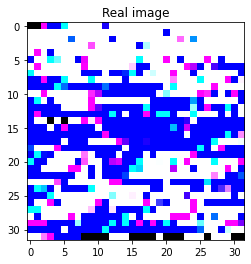

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


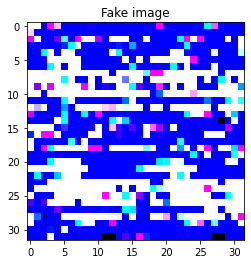

 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Epoch 181
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  16.870704174041748
Discriminator loss:  1.6774397194385529
Epoch 182
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  12.593317031860352
Discriminator loss:  1.6774397194385529
Epoch 183
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  9.130292117595673
Discriminator loss:  1.6985027492046356
Epoch 184
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.7483876943588257
Discriminator loss:  1.6985027492046356
Epoch 185
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  14.326024889945984
Discriminator loss:  1.6985027492046356
Epoch 186
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  25.906933784484863
Discriminator loss:  1.885229915380478
Epoch 187
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  22.032543063163757
Discriminator loss:  1.885229915380478
Epoch 188
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  20.908862590789795
Discriminator loss:  1.885229915380478
Epoch 189
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  8.981420636177063
Discriminator loss:  1.7351204752922058
Epoch 190
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.18272665143013
Discriminator loss:  1.7351204752922058
Epoch 191
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.8518068939447403
Discriminator loss:  1.7351204752922058
Epoch 192
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0399638265371323
Discriminator loss:  1.6779664754867554
Epoch 193
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6094988957047462
Discriminator loss:  1.6779664754867554
Epoch 194
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5435129255056381
Discriminator loss:  1.6779664754867554
Epoch 195
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.402804397046566
Discriminator loss:  1.6637003421783447
Epoch 196
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.39957620203495026
Discriminator loss:  1.6637003421783447
Epoch 197
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2852367162704468
Discriminator loss:  1.6637003421783447
Epoch 198
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.38531533256173134
Discriminator loss:  1.661610186100006
Epoch 199
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.788206085562706
Discriminator loss:  1.661610186100006
Epoch 200
Noise std:  5.0


100%|██████████| 5/5 [00:01<00:00,  4.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.4680259674787521
Discriminator loss:  1.661610186100006


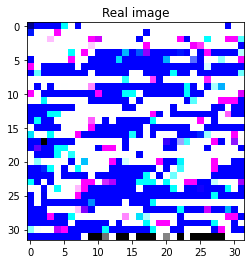

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


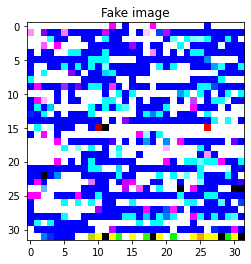

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 201
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  8.855752527713776
Discriminator loss:  1.6625951528549194
Epoch 202
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  23.626307010650635
Discriminator loss:  1.6625951528549194
Epoch 203
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  31.308738708496094
Discriminator loss:  1.6625951528549194
Epoch 204
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  37.06617021560669
Discriminator loss:  1.720430701971054
Epoch 205
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  35.36511707305908
Discriminator loss:  1.720430701971054
Epoch 206
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  35.822529792785645
Discriminator loss:  1.720430701971054
Epoch 207
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  31.782256603240967
Discriminator loss:  1.6905480921268463
Epoch 208
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  35.47740602493286
Discriminator loss:  1.6905480921268463
Epoch 209
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  53.50600337982178
Discriminator loss:  1.6905480921268463
Epoch 210
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  59.05531883239746
Discriminator loss:  1.7517739534378052
Epoch 211
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  57.23855113983154
Discriminator loss:  1.7517739534378052
Epoch 212
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  41.123148918151855
Discriminator loss:  1.7517739534378052
Epoch 213
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  33.59269666671753
Discriminator loss:  1.6666686236858368
Epoch 214
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  30.463512897491455
Discriminator loss:  1.6666686236858368
Epoch 215
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  27.558292865753174
Discriminator loss:  1.6666686236858368
Epoch 216
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  25.144574642181396
Discriminator loss:  1.6779404878616333
Epoch 217
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  24.32984972000122
Discriminator loss:  1.6779404878616333
Epoch 218
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  21.688905954360962
Discriminator loss:  1.6779404878616333
Epoch 219
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  14.070966482162476
Discriminator loss:  1.662839412689209
Epoch 220
Noise std:  5.0


100%|██████████| 5/5 [00:01<00:00,  4.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  11.472799301147461
Discriminator loss:  1.662839412689209


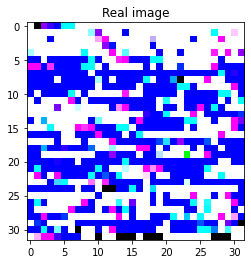

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


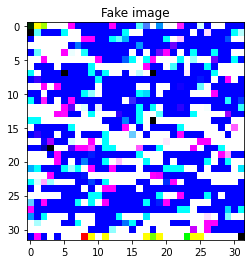

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 221
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  12.308822870254517
Discriminator loss:  1.662839412689209
Epoch 222
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  33.65438508987427
Discriminator loss:  1.742235243320465
Epoch 223
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  46.79432654380798
Discriminator loss:  1.742235243320465
Epoch 224
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  46.507126808166504
Discriminator loss:  1.742235243320465
Epoch 225
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  35.414124488830566
Discriminator loss:  1.6865193247795105
Epoch 226
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  41.49832487106323
Discriminator loss:  1.6865193247795105
Epoch 227
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  41.262503147125244
Discriminator loss:  1.6865193247795105
Epoch 228
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  28.943305492401123
Discriminator loss:  1.6862768530845642
Epoch 229
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  34.12222862243652
Discriminator loss:  1.6862768530845642
Epoch 230
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  47.44320774078369
Discriminator loss:  1.6862768530845642
Epoch 231
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  44.20311737060547
Discriminator loss:  1.6847895383834839
Epoch 232
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  28.170323371887207
Discriminator loss:  1.6847895383834839
Epoch 233
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  23.159823894500732
Discriminator loss:  1.6847895383834839
Epoch 234
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Generator loss:  25.367990970611572
Discriminator loss:  1.690858244895935
Epoch 235
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  22.28091049194336
Discriminator loss:  1.690858244895935
Epoch 236
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  21.458247661590576
Discriminator loss:  1.690858244895935
Epoch 237
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  28.396326065063477
Discriminator loss:  1.6720307767391205
Epoch 238
Noise std:  5.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  30.60242462158203
Discriminator loss:  1.6720307767391205
Epoch 239
Noise std:  5.0


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  27.2054123878479
Discriminator loss:  1.6720307767391205
Epoch 240
Noise std:  5.0


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  19.688766717910767
Discriminator loss:  1.676010638475418


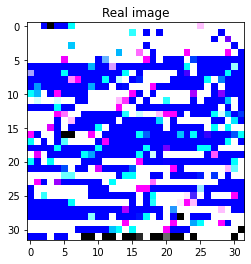

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


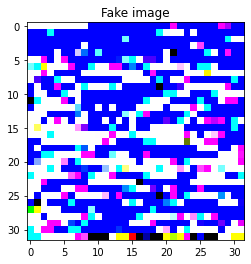

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 241
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  19.635685920715332
Discriminator loss:  1.676010638475418
Epoch 242
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  19.205477714538574
Discriminator loss:  1.676010638475418
Epoch 243
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  24.702985286712646
Discriminator loss:  1.660768300294876
Epoch 244
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  27.141462326049805
Discriminator loss:  1.660768300294876
Epoch 245
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Generator loss:  21.999881505966187
Discriminator loss:  1.660768300294876
Epoch 246
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  18.100473403930664
Discriminator loss:  1.6507611572742462
Epoch 247
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  22.99721908569336
Discriminator loss:  1.6507611572742462
Epoch 248
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  20.10628914833069
Discriminator loss:  1.6507611572742462
Epoch 249
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.51it/s]

Generator loss:  94.9616003036499
Discriminator loss:  1.7627198696136475
Epoch 250
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.41it/s]

Generator loss:  52.29272174835205
Discriminator loss:  1.7627198696136475
Epoch 251
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.52it/s]

Generator loss:  36.03239154815674
Discriminator loss:  1.7627198696136475
Epoch 252
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  24.26233720779419
Discriminator loss:  1.6564889252185822
Epoch 253
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  12.51242446899414
Discriminator loss:  1.6564889252185822
Epoch 254
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  9.341364860534668
Discriminator loss:  1.6564889252185822
Epoch 255
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.63it/s]

Generator loss:  21.298542499542236
Discriminator loss:  1.6820429861545563
Epoch 256
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  65.10962104797363
Discriminator loss:  1.6820429861545563
Epoch 257
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.78it/s]

Generator loss:  48.963242053985596
Discriminator loss:  1.6820429861545563
Epoch 258
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  25.373097896575928
Discriminator loss:  1.6656362116336823
Epoch 259
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  6.295302867889404
Discriminator loss:  1.6656362116336823
Epoch 260
Noise std:  1.6666666666666667


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.40557850897312164
Discriminator loss:  1.6656362116336823


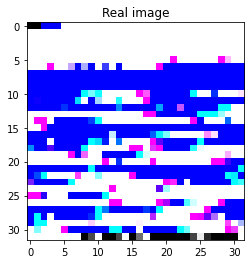

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


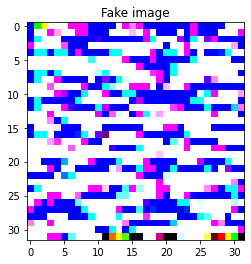

 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Epoch 261
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.41it/s]

Generator loss:  0.30468956008553505
Discriminator loss:  1.6502252519130707
Epoch 262
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.88it/s]

Generator loss:  0.34220635890960693
Discriminator loss:  1.6502252519130707
Epoch 263
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.54it/s]

Generator loss:  0.338038083165884
Discriminator loss:  1.6502252519130707
Epoch 264
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Generator loss:  0.16476230882108212
Discriminator loss:  1.646826148033142
Epoch 265
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.19945421069860458
Discriminator loss:  1.646826148033142
Epoch 266
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.3169765956699848
Discriminator loss:  1.646826148033142
Epoch 267
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.4569690600037575
Discriminator loss:  1.6413534879684448
Epoch 268
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4146960526704788
Discriminator loss:  1.6413534879684448
Epoch 269
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.92it/s]

Generator loss:  0.4919636771082878
Discriminator loss:  1.6413534879684448
Epoch 270
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.83it/s]

Generator loss:  0.7056254670023918
Discriminator loss:  1.645841896533966
Epoch 271
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  0.925613708794117
Discriminator loss:  1.645841896533966
Epoch 272
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.56it/s]

Generator loss:  12.957318663597107
Discriminator loss:  1.645841896533966
Epoch 273
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  58.07383632659912
Discriminator loss:  1.671094387769699
Epoch 274
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Generator loss:  104.77289772033691
Discriminator loss:  1.671094387769699
Epoch 275
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Generator loss:  79.48696041107178
Discriminator loss:  1.671094387769699
Epoch 276
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.46it/s]

Generator loss:  56.091572761535645
Discriminator loss:  1.657689481973648
Epoch 277
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.55it/s]

Generator loss:  38.53889513015747
Discriminator loss:  1.657689481973648
Epoch 278
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  31.060316562652588
Discriminator loss:  1.657689481973648
Epoch 279
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.59it/s]

Generator loss:  16.126189947128296
Discriminator loss:  1.6551729142665863
Epoch 280
Noise std:  1.6666666666666667


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  4.290430814027786
Discriminator loss:  1.6551729142665863


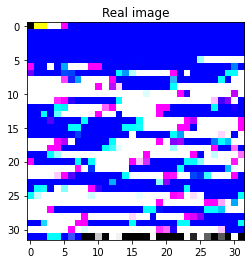

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


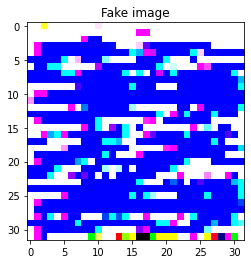

 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Epoch 281
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.9305981993675232
Discriminator loss:  1.6551729142665863
Epoch 282
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.57it/s]

Generator loss:  0.5298792794346809
Discriminator loss:  1.6445870101451874
Epoch 283
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.4956040158867836
Discriminator loss:  1.6445870101451874
Epoch 284
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.50it/s]

Generator loss:  0.7332490682601929
Discriminator loss:  1.6445870101451874
Epoch 285
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.7007556781172752
Discriminator loss:  1.6405109465122223
Epoch 286
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  0.7843373194336891
Discriminator loss:  1.6405109465122223
Epoch 287
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Generator loss:  1.848319262266159
Discriminator loss:  1.6405109465122223
Epoch 288
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  10.666158616542816
Discriminator loss:  1.6456177830696106
Epoch 289
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.58it/s]

Generator loss:  27.898669242858887
Discriminator loss:  1.6456177830696106
Epoch 290
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  36.297133922576904
Discriminator loss:  1.6456177830696106
Epoch 291
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  32.11839151382446
Discriminator loss:  1.6614519655704498
Epoch 292
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.51it/s]

Generator loss:  17.931407928466797
Discriminator loss:  1.6614519655704498
Epoch 293
Noise std:  1.6666666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  12.125981092453003
Discriminator loss:  1.6614519655704498
Epoch 294
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  6.205336272716522
Discriminator loss:  1.6447567641735077
Epoch 295
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  2.4430010318756104
Discriminator loss:  1.6447567641735077
Epoch 296
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.92it/s]

Generator loss:  2.3348610550165176
Discriminator loss:  1.6447567641735077
Epoch 297
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.50it/s]

Generator loss:  3.636603981256485
Discriminator loss:  1.6420188546180725
Epoch 298
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Generator loss:  7.9201130867004395
Discriminator loss:  1.6420188546180725
Epoch 299
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  8.459261298179626
Discriminator loss:  1.6420188546180725
Epoch 300
Noise std:  1.6666666666666667


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  14.717296838760376
Discriminator loss:  1.6534458696842194


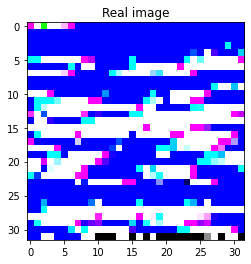

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


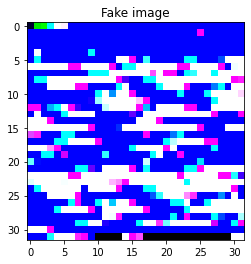

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 301
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.36it/s]

Generator loss:  17.437192678451538
Discriminator loss:  1.6534458696842194
Epoch 302
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.46it/s]

Generator loss:  21.507742404937744
Discriminator loss:  1.6534458696842194
Epoch 303
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Generator loss:  25.291526794433594
Discriminator loss:  1.6861091554164886
Epoch 304
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  12.511386424303055
Discriminator loss:  1.6861091554164886
Epoch 305
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.67it/s]

Generator loss:  1.1003836691379547
Discriminator loss:  1.6861091554164886
Epoch 306
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  1.3298286944627762
Discriminator loss:  1.6418216526508331
Epoch 307
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.8594038188457489
Discriminator loss:  1.6418216526508331
Epoch 308
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.6604202911257744
Discriminator loss:  1.6418216526508331
Epoch 309
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  1.7686845660209656
Discriminator loss:  1.6475147902965546
Epoch 310
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  1.183144971728325
Discriminator loss:  1.6475147902965546
Epoch 311
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.55it/s]

Generator loss:  1.6177248358726501
Discriminator loss:  1.6475147902965546
Epoch 312
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.50it/s]

Generator loss:  3.257450222969055
Discriminator loss:  1.6375417113304138
Epoch 313
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  4.157593548297882
Discriminator loss:  1.6375417113304138
Epoch 314
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.54it/s]

Generator loss:  1.5953561961650848
Discriminator loss:  1.6375417113304138
Epoch 315
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Generator loss:  1.4189146757125854
Discriminator loss:  1.6441211104393005
Epoch 316
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.78it/s]

Generator loss:  0.7826522439718246
Discriminator loss:  1.6441211104393005
Epoch 317
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  1.0912352949380875
Discriminator loss:  1.6441211104393005
Epoch 318
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.50it/s]

Generator loss:  2.8440078496932983
Discriminator loss:  1.6429105997085571
Epoch 319
Noise std:  1.6666666666666667


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  7.781899809837341
Discriminator loss:  1.6429105997085571
Epoch 320
Noise std:  1.6666666666666667


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  4.469430208206177
Discriminator loss:  1.6429105997085571


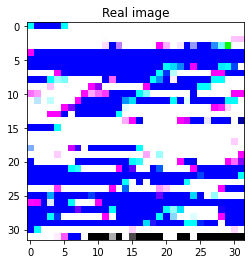

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


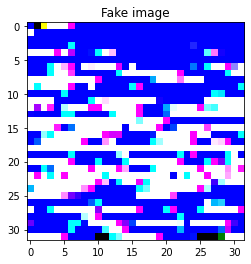

 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Epoch 321
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.63it/s]

Generator loss:  7.443785905838013
Discriminator loss:  1.6432354152202606
Epoch 322
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.51it/s]

Generator loss:  16.720000743865967
Discriminator loss:  1.6432354152202606
Epoch 323
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.65it/s]

Generator loss:  25.93922919034958
Discriminator loss:  1.6432354152202606
Epoch 324
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Generator loss:  41.87614023685455
Discriminator loss:  2.243458926677704
Epoch 325
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  1.7810441814363003
Discriminator loss:  2.243458926677704
Epoch 326
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.69it/s]

Generator loss:  0.5305899307131767
Discriminator loss:  2.243458926677704
Epoch 327
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  0.48058008402585983
Discriminator loss:  1.6486397683620453
Epoch 328
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.64it/s]

Generator loss:  0.3893686980009079
Discriminator loss:  1.6486397683620453
Epoch 329
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.33037276193499565
Discriminator loss:  1.6486397683620453
Epoch 330
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.3168579339981079
Discriminator loss:  1.640286535024643
Epoch 331
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  0.3704940266907215
Discriminator loss:  1.640286535024643
Epoch 332
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  0.3345273323357105
Discriminator loss:  1.640286535024643
Epoch 333
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.3837970197200775
Discriminator loss:  1.6406952738761902
Epoch 334
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  0.3281606063246727
Discriminator loss:  1.6406952738761902
Epoch 335
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Generator loss:  0.3703579902648926
Discriminator loss:  1.6406952738761902
Epoch 336
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Generator loss:  0.3206883817911148
Discriminator loss:  1.6369273364543915
Epoch 337
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.50it/s]

Generator loss:  0.3765949159860611
Discriminator loss:  1.6369273364543915
Epoch 338
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.49it/s]

Generator loss:  0.3703758418560028
Discriminator loss:  1.6369273364543915
Epoch 339
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.71it/s]

Generator loss:  0.3965187221765518
Discriminator loss:  1.63766747713089
Epoch 340
Noise std:  1.0


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.4416329190135002
Discriminator loss:  1.63766747713089


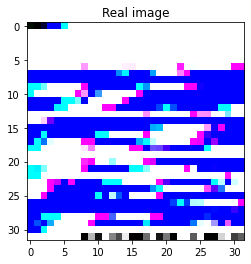

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


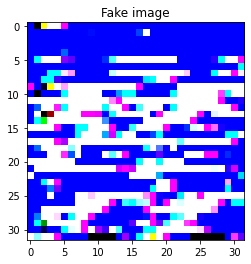

 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Epoch 341
Noise std:  1.0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4701954200863838
Discriminator loss:  1.63766747713089
Epoch 342
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.4942225143313408
Discriminator loss:  1.6351677477359772
Epoch 343
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.4862205684185028
Discriminator loss:  1.6351677477359772
Epoch 344
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.4885472506284714
Discriminator loss:  1.6351677477359772
Epoch 345
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  0.492692232131958
Discriminator loss:  1.6351645588874817
Epoch 346
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.40839140862226486
Discriminator loss:  1.6351645588874817
Epoch 347
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.48it/s]

Generator loss:  0.4118117466568947
Discriminator loss:  1.6351645588874817
Epoch 348
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  0.41997794806957245
Discriminator loss:  1.6347684264183044
Epoch 349
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Generator loss:  0.5225538462400436
Discriminator loss:  1.6347684264183044
Epoch 350
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  0.48514843732118607
Discriminator loss:  1.6347684264183044
Epoch 351
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.48it/s]

Generator loss:  0.5574963465332985
Discriminator loss:  1.63846355676651
Epoch 352
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.5619726702570915
Discriminator loss:  1.63846355676651
Epoch 353
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.62it/s]

Generator loss:  0.5616945028305054
Discriminator loss:  1.63846355676651
Epoch 354
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.6143961548805237
Discriminator loss:  1.6365015506744385
Epoch 355
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  0.7169248163700104
Discriminator loss:  1.6365015506744385
Epoch 356
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.9148387461900711
Discriminator loss:  1.6365015506744385
Epoch 357
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  0.7705375105142593
Discriminator loss:  1.6366468369960785
Epoch 358
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.49it/s]

Generator loss:  0.7180159837007523
Discriminator loss:  1.6366468369960785
Epoch 359
Noise std:  1.0


 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Generator loss:  0.874188169836998
Discriminator loss:  1.6366468369960785
Epoch 360
Noise std:  1.0


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.3746661096811295
Discriminator loss:  1.6392182111740112


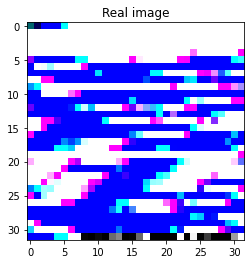

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


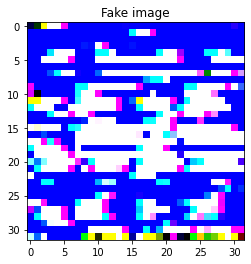

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 361
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0973188430070877
Discriminator loss:  1.6392182111740112
Epoch 362
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.51it/s]

Generator loss:  1.422070786356926
Discriminator loss:  1.6392182111740112
Epoch 363
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.76it/s]

Generator loss:  2.217566341161728
Discriminator loss:  1.6348776519298553
Epoch 364
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  3.0532437562942505
Discriminator loss:  1.6348776519298553
Epoch 365
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  10.443479537963867
Discriminator loss:  1.6348776519298553
Epoch 366
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.68it/s]

Generator loss:  22.737957239151
Discriminator loss:  1.644335389137268
Epoch 367
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.63it/s]

Generator loss:  51.46399688720703
Discriminator loss:  1.644335389137268
Epoch 368
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  61.35289287567139
Discriminator loss:  1.644335389137268
Epoch 369
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  60.54765319824219
Discriminator loss:  1.6485018134117126
Epoch 370
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  53.585533142089844
Discriminator loss:  1.6485018134117126
Epoch 371
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  43.106003761291504
Discriminator loss:  1.6485018134117126
Epoch 372
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.48it/s]

Generator loss:  32.0959906578064
Discriminator loss:  1.6394713521003723
Epoch 373
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  21.546204090118408
Discriminator loss:  1.6394713521003723
Epoch 374
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  18.172013521194458
Discriminator loss:  1.6394713521003723
Epoch 375
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.60it/s]

Generator loss:  19.045690298080444
Discriminator loss:  1.6432040333747864
Epoch 376
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  27.599567413330078
Discriminator loss:  1.6432040333747864
Epoch 377
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.80it/s]

Generator loss:  36.455851554870605
Discriminator loss:  1.6432040333747864
Epoch 378
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  37.64382314682007
Discriminator loss:  1.6378099024295807
Epoch 379
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.36it/s]

Generator loss:  45.57331466674805
Discriminator loss:  1.6378099024295807
Epoch 380
Noise std:  0


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  41.334943771362305
Discriminator loss:  1.6378099024295807


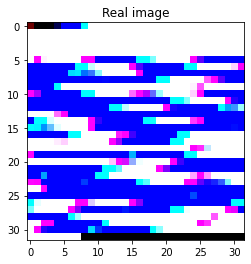

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


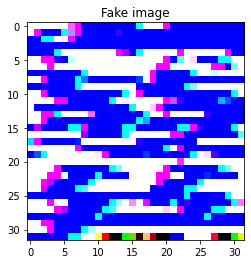

 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Epoch 381
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.49it/s]

Generator loss:  40.66339826583862
Discriminator loss:  1.6388663351535797
Epoch 382
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.56it/s]

Generator loss:  36.077232360839844
Discriminator loss:  1.6388663351535797
Epoch 383
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  31.713032722473145
Discriminator loss:  1.6388663351535797
Epoch 384
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  29.72828435897827
Discriminator loss:  1.6472561955451965
Epoch 385
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.69it/s]

Generator loss:  18.89968252182007
Discriminator loss:  1.6472561955451965
Epoch 386
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  27.129343032836914
Discriminator loss:  1.6472561955451965
Epoch 387
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Generator loss:  42.81751346588135
Discriminator loss:  1.6455310583114624
Epoch 388
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  47.11953163146973
Discriminator loss:  1.6455310583114624
Epoch 389
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.80it/s]

Generator loss:  35.92270612716675
Discriminator loss:  1.6455310583114624
Epoch 390
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  29.21608877182007
Discriminator loss:  1.6357482075691223
Epoch 391
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  43.558505058288574
Discriminator loss:  1.6357482075691223
Epoch 392
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.66it/s]

Generator loss:  35.433785915374756
Discriminator loss:  1.6357482075691223
Epoch 393
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  32.51472759246826
Discriminator loss:  1.6478231251239777
Epoch 394
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  39.168171405792236
Discriminator loss:  1.6478231251239777
Epoch 395
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Generator loss:  36.05532217025757
Discriminator loss:  1.6478231251239777
Epoch 396
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.61it/s]

Generator loss:  35.54718828201294
Discriminator loss:  1.6465433835983276
Epoch 397
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.51it/s]

Generator loss:  25.033883094787598
Discriminator loss:  1.6465433835983276
Epoch 398
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  21.726919174194336
Discriminator loss:  1.6465433835983276
Epoch 399
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.92it/s]

Generator loss:  29.429155349731445
Discriminator loss:  1.6401251554489136
Epoch 400
Noise std:  0


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  21.85906171798706
Discriminator loss:  1.6401251554489136


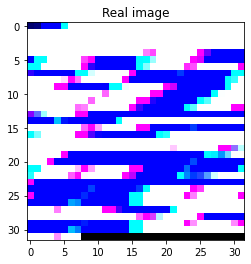

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


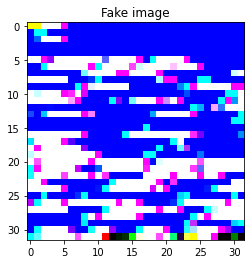

In [72]:
loss_generator,loss_discriminator = g_CNN.train(X,100,20)

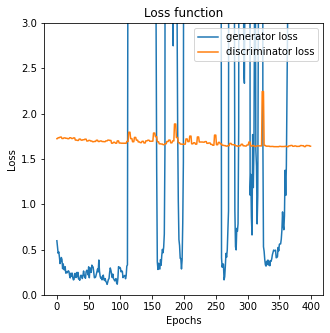

In [95]:
plt.figure(figsize=(5,5))
plt.plot(loss_generator)
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss','discriminator loss'])
#plt.ylim([0,])
plt.show()

## Evaluation plots

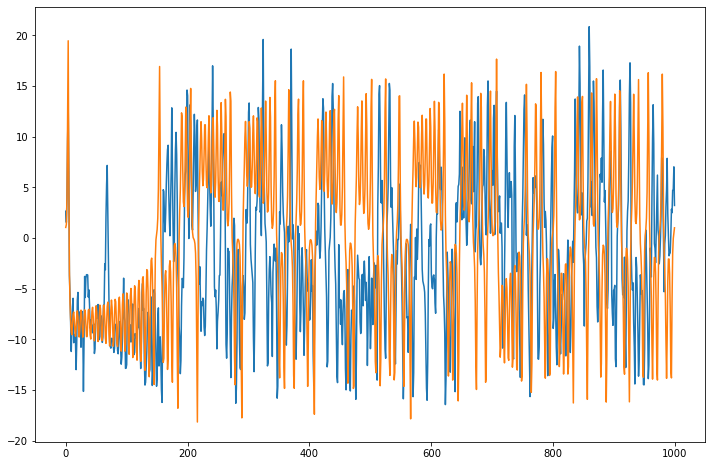

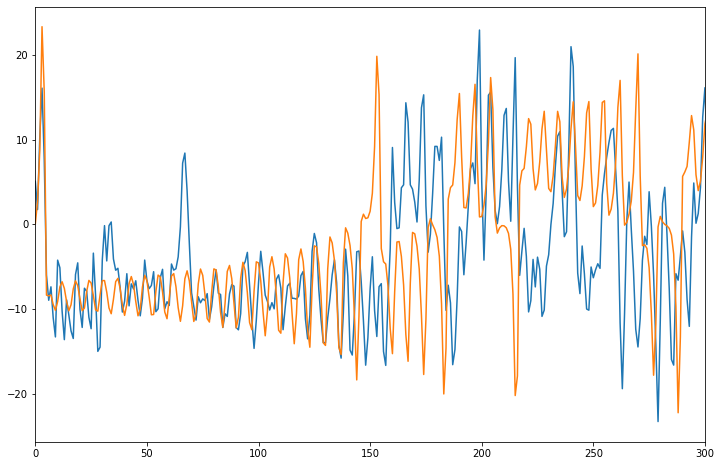

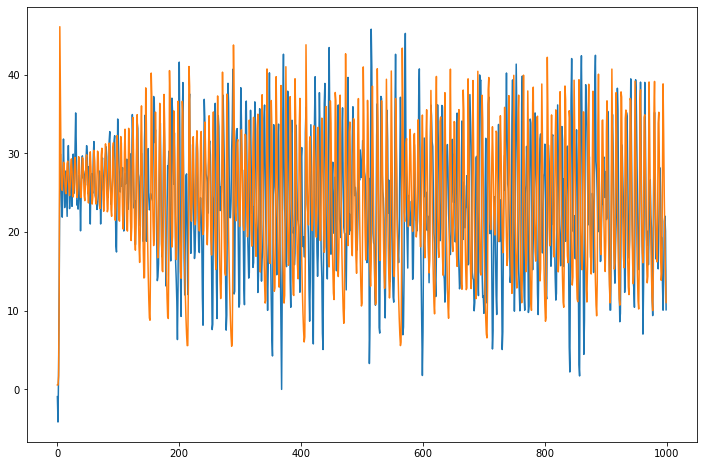

In [76]:
real_series_length = 1000
x = X[0,...].reshape(X.shape[1]*X.shape[2],X.shape[3])[:real_series_length]
#max_matrix = np.repeat(np.max(abs(x_train),axis=0).reshape(1,3),1000,axis=0)
#x_train = np.divide(x_train,max_matrix)

generated_data = g_CNN.generate(1)
generated_data = generated_data[0,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,0])
plt.plot(x_train[:,0])
#plt.xlim([0,200])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,1])
plt.plot(x_train[:,1])
plt.xlim([0,300])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,2])
plt.plot(x_train[:,2])
plt.show()

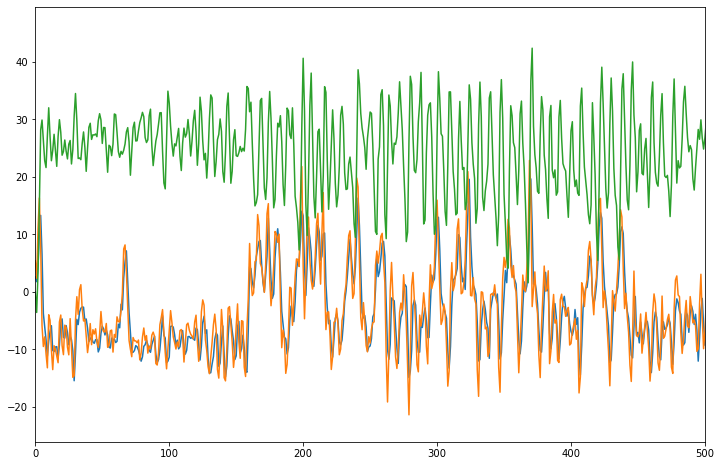

In [91]:
generated_data = g_CNN.generate(1)
generated_data = generated_data[0,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,0])
plt.plot(generated_data[:,1])
plt.plot(generated_data[:,2])
plt.xlim([0,500])
plt.show()

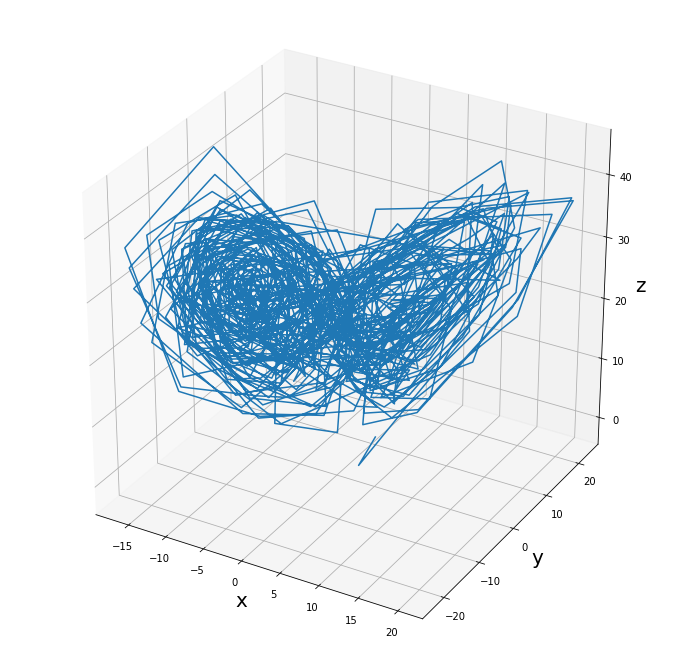

In [94]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot(generated_data[:,0], generated_data[:,1], generated_data[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.show()

## We save and load the model

In [80]:
g_CNN.save_weights('gen3channels.h5','discr3channels.h5')

In [82]:
gLoaded = gan_CNN()
gLoaded.load_weights('gen3channels.h5','discr3channels.h5')

(None, 300)
